In [225]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [226]:
# Read the raw data
data = pd.read_csv('./data/ULEV Registrations As of 2022.csv')

# Clean up and reorganize data

# We only care about the ONS Sort (geographic classification) or the quarterly registration
# ONS Sort is an integer but not continuous (e.g. jumps from 17 to 20). So it's better keep this number to avoid confusion
data = data.filter(regex=r'ONS Sort|Q')

# Melt the data to put quarter as a number instead of a column
data = data.melt(id_vars='ONS Sort', var_name='Quarter', value_name='val')
data['Quarter'] = data['Quarter'].str.extract('(\d+)', expand=False).astype(int)
data['

data = data.sort_values(['Quarter', 'ONS Sort'])

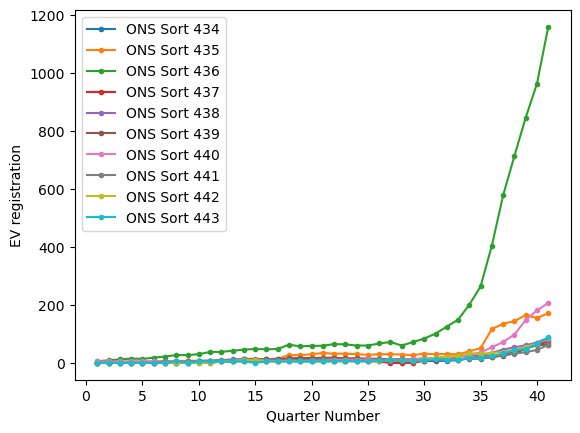

In [227]:
# Now let's try to plot some data
for ons in data["ONS Sort"].tail(10):
    plt.plot(np.arange(1,42,1), data[data["ONS Sort"] == ons]["val"], ".-", label="ONS Sort %d" % ons)

plt.xlabel("Quarter Number")
plt.ylabel("EV registration")
plt.legend()
plt.show()

In [230]:
from sklearn.preprocessing import OneHotEncoder

# Initialize an encoder to process ONS Sort as an categorical data
enc = OneHotEncoder(handle_unknown = "ignore")
data.assign("ONS Sort" = enc.fit_transform(data["ONS Sort"].to_numpy().reshape(-1, 1)))

# A function that expand each row (datapoint) with features
def append_feats(x, mean_period):
    
    # Caveats: the last quarter doesn't have next_val and the first quarter doesn't have prev_val
    # We don't use these incomplete data
    x["prev_val"] = x.groupby('ONS Sort')["val"].shift(1)
    x["next_val"] = x.groupby('ONS Sort')["val"].shift(-1)
    x["mean"] = x.groupby("ONS Sort")["val"].rolling(mean_period).mean().reset_index(level=0, drop=True)
    
append_feats(data, 4)
data

TypeError: DataFrame.assign() takes 1 positional argument but 2 were given

In [190]:
# Split the data set into test, train, and valid set

# Use random splitting to try avoid overfitting
from sklearn.model_selection import train_test_split

raw_data = data

data = data[data["Quarter"].between(4, 40)]

# Split the entire dataset into two: training and the test & valid subsets
# No random splitting
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = False)

raw_data_train, raw_data_test = train_test_split(raw_data, test_size = 0.1, shuffle = False)

print(raw_data_train.shape)

print(data_train.shape)

# Split the test & valid subset into test and valid subsets
# data_test, data_valid = train_test_split(data_test_and_valid, test_size = 0.5, shuffle = False)

(15534, 6)
(14019, 6)


In [162]:
# Let's do the grid search on the parameters of Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

features = ['ONS Sort', 'val', 'prev_val', 'mean', 'Quarter' ]

# Set up the parameter grid
param_grid = {
    'n_estimators': [10, 30, 100],
    'max_depth': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf_reg = RandomForestRegressor()

# Setup a time series cross validator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
# Every split is a superset of the previous split
tscv = TimeSeriesSplit()

# Set up the grid search
grid_search = GridSearchCV(rf_reg, param_grid, cv=tscv, return_train_score = True)

# Fit the grid search to the data_valid
grid_search.fit(enc.transform(data_train[features]), data_train["next_val"])

# Print the best parameters and best score
# Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Best score: 0.8753975290671674
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

rf_params = grid_search.best_params_

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Best score: 0.692254844648003


In [177]:
from sklearn.ensemble import RandomForestRegressor

features = ['ONS Sort', 'val', 'prev_val', 'mean', 'Quarter' ]

# Train the model
rf_mdl = RandomForestRegressor(max_depth =  10, min_samples_leaf = 1, min_samples_split= 2, n_estimators= 10)
rf_mdl.fit(enc.transform(data_train[features]), data_train["next_val"])

RandomForestRegressor(max_depth=10, n_estimators=10)

In [ ]:
# Let's see how the model performs

from sklearn import metrics

# mape from sklearn has some problem on 0 y_true value which somehow we couldn't supress
# Also wmape seems more reasonable
# from sklearn.metrics import mean_absolute_percentage_error as mape

def mape(y_true, y_pred):
    #Mean average percentage error
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    #weight mean average percentage error
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# 0.2046258275246929
print(enc.transform(data_test[features]))
print(mape(data_test["next_val"], rf_mdl.predict(enc.transform(data_test[features]))))

# 0.23171836132745552
# wmape(data_test["next_val"], rf_mdl.predict(data_test[features]))

# R2 scoring
# 0.8901629714568271
# metrics.r2_score(data_test["next_val"], rf_mdl.predict(data_test[features]))


# for i in data_test["ONS Sort"]:
for i in data_test["ONS Sort"]:
    if int(i) <= 9:
        plt.scatter(i, metrics.r2_score(data_test[data_test["ONS Sort"] == i]["next_val"], rf_mdl.predict(enc.transform(data_test[data_test["ONS Sort"] == i][features]))), marker = "o")
    
plt.show()

<1558x5567 sparse matrix of type '<class 'numpy.float64'>'
	with 7790 stored elements in Compressed Sparse Row format>

In [63]:
# Try different models

# Gradient boosting

# Import necessary modules
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameters for grid search
gb_param_grid = {
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [100, 150, 200],
    "max_depth": [3, 4, 5]
}

# Initialize the gradient boosting regressor
gb_regressor = GradientBoostingRegressor()

# Setup a time series cross validator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
# Every split is a superset of the previous split
tscv = TimeSeriesSplit()

# Use grid search to find the best combination of hyperparameters
gb_regressor_cv = GridSearchCV(gb_regressor, gb_param_grid, cv=tscv)

gb_regressor_cv.fit(data_train[features], data_train["next_val"])

# Print the best hyperparameters
# Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
print("Best hyperparameters:", gb_regressor_cv.best_params_)
print('Best score:', grid_search.best_score_)

gb_params = grid_search.best_params_

Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
Best score: 0.874408535297254


In [64]:
# Gradient boosting continued.
# Import necessary modules
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gb_regressor = GradientBoostingRegressor(learning_rate = 0.2, max_depth = 3, n_estimators = 150)

gb_regressor.fit(data_train[features], data_train["next_val"])

GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)

In [69]:
# 0.2183431330433336
mape(data_test["next_val"], gb_regressor.predict(data_test[features]))

# 0.2304218191028904
wmape(data_test["next_val"], gb_regressor.predict(data_test[features]))

# Doesn't seem to be better

# 0.8955736980625465
# gb_regressor.score(data_test[features], data_test["next_val"])
metrics.r2_score(data_test["next_val"], gb_regressor.predict(data_test[features]))

0.8955736980625465

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[9]             : AIC=225.490, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[9]             : AIC=217.485, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[9]             : AIC=219.216, Time=0.16 sec
 ARIMA(0,2,1)(0,0,1)[9]             : AIC=219.111, Time=0.15 sec
 ARIMA(0,2,0)(1,0,0)[9]             : AIC=218.455, Time=0.22 sec
 ARIMA(0,2,0)(0,0,1)[9]             : AIC=218.306, Time=0.15 sec
 ARIMA(0,2,0)(1,0,1)[9]             : AIC=220.253, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[9]             : AIC=218.240, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[9]             : AIC=218.060, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[9]             : AIC=220.022, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[9] intercept   : AIC=218.477, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[9]          
Total fit time: 1.566 seconds
R^2 for ONS Sort 21: -25.555147


/nix/store/yf7x73dbdl8dscrdic2dp4brg2dhpf8p-python3-3.10.8-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


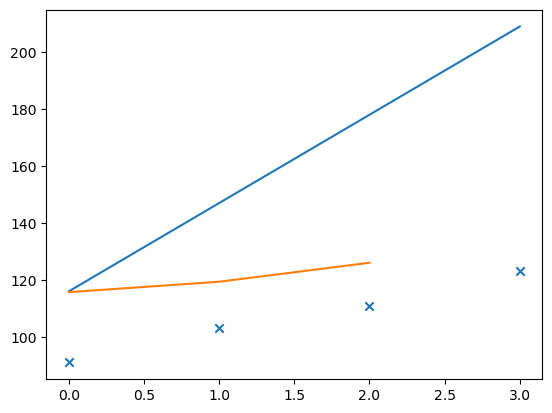

In [146]:
# Let's try ARIMA

# Import necessary modules
import pmdarima as pm
from pmdarima import model_selection

# for region in raw_data_train["ONS Sort"].head(20):
for region in range(21,22):
    data_train_regional = raw_data_train[raw_data_train["ONS Sort"] == region]
    data_test_regional = raw_data_test[raw_data_test["ONS Sort"] == region]
    # Fit the ARIMA model to the time series, specifying the hyperparameters
    # NOTE: m is the seasonal parameter and should be set to 4
    # However, due to pmdarima bug (probably), it leads to NaN
    arima = pm.auto_arima(data_train_regional["val"], error_action='ignore', trace=True,
                      suppress_warnings=True, m = 9,
                     max_order=None,
                      seasonal=True)
    
    # arima.plot_diagnostics()
    
    # print(data_train_regional["val"])
    # print(data_test_regional.shape[0])
    
    
    # Generate prediction
    prediction = arima.predict(n_periods=data_test_regional.shape[0])
    
    print("R^2 for ONS Sort %d: %f" % (region, metrics.r2_score(data_test_regional["val"], prediction)))
    # plt.scatter(region, metrics.r2_score(data_test_regional["val"], prediction), marker = "o")
    
    # R^2 = -25?
    if region == 21:
       x = np.arange(data_test_regional.shape[0])
       plt.scatter(x, data_test_regional['val'], marker='x', label = "ONS Sort %d" % region)
       plt.plot(x, prediction, label = "ONS Sort %d" % region)
       plt.plot(np.arange(3), rf_mdl.predict(data_test[data_test["ONS Sort"] == region][features]), label = "ONS Sort %d" % region)
    
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

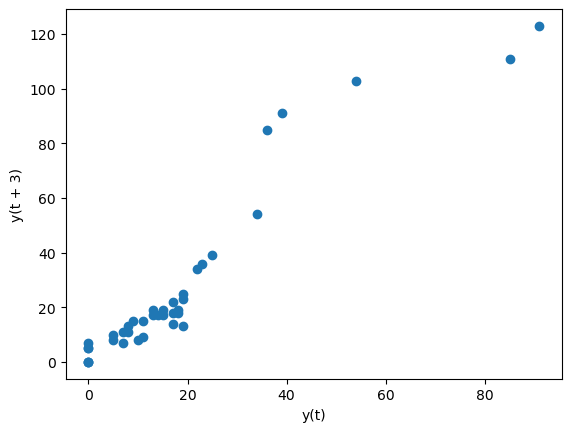

In [147]:
# Let's look at the lag plot

pd.plotting.lag_plot(raw_data[raw_data["ONS Sort"] == 21]["val"], lag=3)